# Sampling algorithm (VE) 테스트.

1. Cartesian에서 sampling을 하는경우와 distance space에서 샘플링을 하는 경우를 다룸.
2. Time-reversal 샘플링 과정에서 $h$ 를 없애고 샘플링을 하는것을 고려중

- Reference: *Zhou, L., Lou, A., Khanna, S., & Ermon, S. (2023). Denoising Diffusion Bridge Models. arXiv preprint arXiv:2309.16948.*

---
Time reversal sampling은 $x_{t} = x_{t+1} - dx_{t}$ 꼴으로 진행된다.

$$dx_{t}=\left[f(x_t, t) - g^2(t)\left(s(x_t, t, x_0, x_T)-h(x_t , t, x_T) \right)\right]dt + g(t)dw_t$$

여기서 

$$ s(x_t, t, x_0, T) = \nabla_{x_t} \log q(x_t \vert x_0, x_T) = (\mu_t - x_t) / \hat{\sigma}^2_t  $$

where, 
$$\mu_t = \frac{\sigma_t^2}{\sigma_T^2} x_T + (1-\frac{\sigma_t^2}{\sigma_T^2}) x_0$$

$$\hat{\sigma}^2_t := \sigma^2_t\left(1-\frac{\sigma_t^2}{\sigma_T^2}\right)$$



In practice,

$$d\sigma^2(t) /dt = \beta(t) = g^2(t)$$

$$\{\beta_{t}\}=\{\beta_0, \beta_1, \beta_2, ..., \beta_{T-1}\}$$

$$\sigma^2_t = \int^t_0 \beta(t) dt = \sum_{i=0}^{t-1}\beta_{i} + \sigma^2_0\quad \forall 1\le t \le T$$

그리고, 실질적으로 discrete하게 SDE를 푸는 과정에서 $h, f = 0$ 이라고 가정하고, wiener process없이 문제를 푼다면 


$$dx_t= -g^2(t)s(x_t, t, x_0, T) dt=- \frac{\beta_t}{\sigma^2_t(1-\sigma^2_t/\sigma^2_T)}(\mu_t - x_t)dt$$

---

### 이번 노트북에서 확인하고 싶은 점
#### d-space SDE sampling은 수렴하지만, q-space SDE sampling이 수렴하지 않는 이유

eq_transform function 으로 q-space score로 x-space update 를 정하는게 이상하다는 생각이 듬.

$\mu_t - x_t$가 eq_transform을 거치면서 죽어버리는 상황이 나오는것 같음.

그것은 Jacobian의 condition number와 관련된게 아닌가?


In [649]:
import numpy as np
import torch

from scipy.spatial.distance import cdist, pdist
import scipy

import os
import ase.io
import ase
import sys

from torch_scatter import scatter_add

from lst_interp import *

import matplotlib.pyplot as plt
# import seaborn as sns

torch.set_num_threads(4)

## fix random seed
def set_seed(seed):
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    np.random.seed(seed)
    return
set_seed(0)

# Sampling Parameters study

1. $\beta_t$의 함수꼴을 sigmoid style을 사용했을 때, $t\to T$ 에서 score가 **매우** 불안정해지는 것을 확인
    - bell shaped curve를 사용하면, 여전히 튀는 현상이 발생하기는 하지만 에러 스케일이 0.01 수준으로 매우 양호해진다.
    - $t\to T$에서 $\beta$를 0 으로 수렴시켜서 update양을 조절하는게 주요하지 않았을까 생각한다.
2. $\sigma_0 = 0$ 이 되면 numerically 문제가 생긴다.
    - 왜냐하면 $(\hat{\sigma}_t)^{-1} \to \infty$ as $t\to 0$.
    - $\sigma_0 \gt 0$ 이면 $\beta_t \to 0$ 으로 만들고, $(\hat{\sigma}_t)^{-1} \lt \infty$ 로 만들 수 있어서 문제를 해결할 수 있다.

---

### $\beta(t)$ is truncated normal distribution, defined on [0, 1]
### $\sigma^2(t)=\int_0^{t}\beta(s)ds + \sigma^2(0)$ 
### $\sigma^2(0)/\int_0^{1}\beta(s)ds = 0.005$


In [650]:
class SamplingParams:
    def __init__(
        self,
        sampling_type,
        c=0.1,
        beta_std=0.125,
        sigma_max=1e-1,
        sigma_min=1e-7,
        sigma1_correction=1e-7,
    ):
        assert sampling_type in ["bell-shaped", "linear", "constant"]
        self.sampling_type = sampling_type
        print(f"Debug: sampling_type = {sampling_type}")

        if sampling_type in ["linear", "constant"]:
            # recommend c=0.1 for "linear", c=np.sqrt(0.1) for "constant"
            self.c = c
            self.sigma_1 = self.sigma_square(1.0)
            self.sigma_0 = self.sigma_square(0.0)
            print(f"Debug: self.c = {self.c}")
            print("Debug: sigma_1, sigma_0 = ", self.sigma_1, self.sigma_0)
        elif sampling_type == "bell-shaped":
            self.sigma_linear_coef = 0.0
            self.beta_std = beta_std
            self.sigma_max = sigma_max
            if sigma_min is None:
                self.sigma_min = sigma_max * 5e-3
            else:
                self.sigma_min = sigma_min
            self.normalizer = 1 / (beta_std * np.sqrt(2 * np.pi))

            self.sigma_1 = self.sigma_square(1.0) + sigma1_correction
            self.sigma_0 = self.sigma_square(0.0)
            # print(self.sigma_1, self.sigma_0)
            print("Debug: std_beta, sigma_max, sigma_min = ", std_beta, sigma_max, sigma_min)
            print("Debug: sigma_1, sigma_0 = ", self.sigma_1, self.sigma_0)
        else:
            raise NotImplementedError
        return

    def beta(self, t):
        if self.sampling_type == "linear":
            b = self.c * 2 * t
        elif self.sampling_type == "constant":
            b = self.c**2 * torch.ones_like(t)
        elif self.sampling_type == "bell-shaped":
            if isinstance(t, torch.Tensor):
                b = torch.exp(-((t - 0.5) / self.beta_std) ** 2 / 2)
            else:
                b = np.exp(-((t - 0.5) / self.beta_std) ** 2 / 2)
            b = b * self.normalizer * self.sigma_max
            b += self.sigma_linear_coef
        else:
            raise NotImplementedError
        return b

    def sigma_square(self, t):
        if self.sampling_type == "linear":
            s_sq = self.c * t**2 + 1e-4
        elif self.sampling_type == "constant":
            s_sq = self.c**2 * t + 1e-3
        elif self.sampling_type == "bell-shaped":
            erf_scaler = self.sigma_max / 2 # / (self.beta_std * np.sqrt(8) * 2)
            if isinstance(t, torch.Tensor):
                s_sq = erf_scaler * (1 + torch.special.erf( (t - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
                s_sq = s_sq - erf_scaler * (1 + scipy.special.erf( (0 - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
                s_sq += self.sigma_linear_coef * t
            else:
                s_sq = erf_scaler * (1 + scipy.special.erf( (t - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
                s_sq = s_sq - erf_scaler * (1 + scipy.special.erf( (0 - 0.5) / (np.sqrt(2) * self.beta_std) )) + self.sigma_min
                s_sq += self.sigma_linear_coef * t
        else:
            raise NotImplementedError
        return s_sq
        
    def SNR(self, t):
        return self.sigma_square(t) / self.sigma_1

Debug: sampling_type = bell-shaped
Debug: std_beta, sigma_max, sigma_min =  0.125 0.1 1e-08
Debug: sigma_1, sigma_0 =  0.09999468575163337 1.9999999999999904e-08


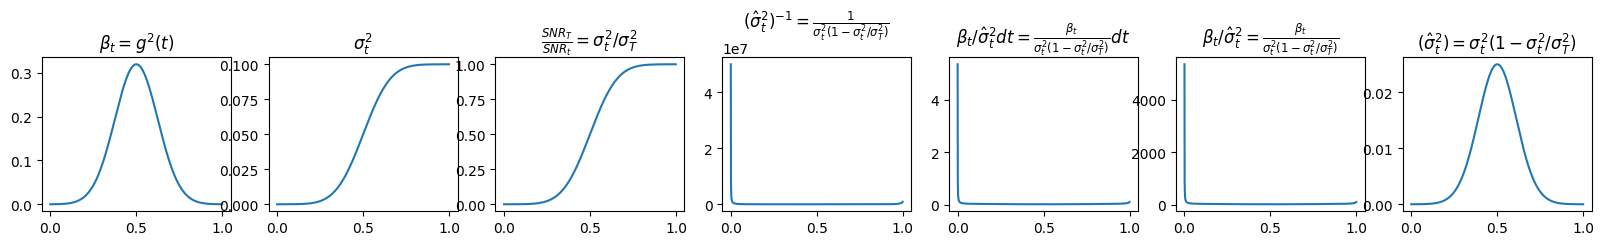

In [651]:
## Set sampling parameters

sampling_type = ["bell-shaped", "linear", "constant"][0]

# for linear and square sampling
c = 0.1

# bell-shaped sampling
std_beta = 0.125
sigma_max = 0.1
sigma_min = 1e-8
sigma1_correction = 1e-6


params = SamplingParams(
    sampling_type=sampling_type,
    c=c,
    beta_std=std_beta,
    sigma_max=sigma_max,
    sigma_min=sigma_min,
    sigma1_correction=sigma1_correction,
    )

## t samples
num_time_steps = 1000
t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
betas = params.beta(t)
sigma_square = params.sigma_square(t)
SNRTt = params.SNR(t)


## plot
fig, axs = plt.subplots(1, 7, figsize=(20, 2))
plt.subplots_adjust(hspace=0.5)
plt.rcParams.update({'font.size': 10})  # Set the global font size to 12
axs = axs.flatten()

ax = axs[0];ax.plot(t, betas);ax.set_title(r"$\beta_t = g^2(t)$")
ax = axs[1];ax.plot(t, sigma_square);ax.set_title("$\sigma_{t}^{2}$")
ax = axs[2];ax.plot(t, SNRTt);ax.set_title(r"$\frac{SNR_{T}}{SNR_{t}}=\sigma_t^2/\sigma_T^2$")
ax = axs[3];ax.set_title(r"$(\hat{\sigma}_t^2)^{-1}=\frac{1}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$");ax.plot(t, (1 / sigma_square / (1 - SNRTt)))
ax = axs[4];ax.set_title(r"$\beta_t/\hat{\sigma}_{t}^2 dt=\frac{\beta_t}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)} dt$");ax.plot(t, (betas / sigma_square / (1 - SNRTt)) * 1 / len(betas))
ax = axs[5];ax.set_title(r"$\beta_t/\hat{\sigma}_{t}^2=\frac{\beta_t}{\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$");ax.plot(t, (betas / sigma_square / (1 - SNRTt)))
ax = axs[6];ax.set_title(r"$(\hat{\sigma}_t^2)={\sigma_t^2(1-\sigma_t^2/\sigma_T^2)}$");ax.plot(t, (1 * sigma_square * (1 - SNRTt)))

In [652]:
a = torch.arange(3)
a.reshape(1, -1) * a.reshape(-1, 1)

tensor([[0, 0, 0],
        [0, 1, 2],
        [0, 2, 4]])

In [653]:
## wrapper class to save atoms object
import sys
sys.path.append("/home/share/DATA/NeuralOpt/Interpolations/Geodesic_interp")
# from get_geodesic_energy import get_rijlist_and_re, compute_wij, morse_scaler
from get_geodesic_energy import morse_scaler, ATOMIC_RADIUS
torch.set_default_dtype(torch.float64)

class Wrapper:
    def __init__(self, atoms_0, atoms_T, q_type="DM", alpha=1.7, beta=0.01, gamma=0.01, using_jacobian=False):
        self.atoms_0 = atoms_0
        self.atoms_T = atoms_T
        # assert q_type in ["DM", "morse"]
        self.q_type = q_type

        self.re = torch.Tensor(self.get_re(atoms_T))
        # self.re = torch.Tensor(self.get_re(atoms_T))
        self.alpha, self.beta = alpha, beta
        self.gamma = gamma
        self.morse_scaler = morse_scaler(self.re, self.alpha, self.beta)
        self.scaler_factor = 1.0; print(f"Debug: self.scaler_factor set to {self.scaler_factor}")
        self.using_jacobian = using_jacobian
        return


    def get_re(self, atoms, threshold=np.inf):
        from scipy.spatial import KDTree

        rijset = set()
        tree = KDTree(atoms.positions)
        pairs = tree.query_pairs(threshold)
        rijset.update(pairs)
        rijlist = sorted(rijset)

        radius = np.array([ATOMIC_RADIUS.get(atom.capitalize(), 1.5) for atom in atoms.get_chemical_symbols()])
        re = np.array([radius[i] + radius[j] for i, j in rijlist])
        return re

    def calc_jacobian(self, pos, q_type):
        # pos = Tensor, (N, 3)
        edge_index, edge_length = self.pos_to_dist(pos)
        distance = pdist(pos)
        distance_e = self.get_re(self.atoms_T)

        jacobian = []
        for i_idx in range(len(pos)):
            j_idx = list(range(len(pos)))
            j_idx.remove(i_idx)
            j_idx = torch.LongTensor(j_idx)

            j_mask = torch.any(edge_index == i_idx, axis=0)
            dd_dx = torch.zeros(size=(len(edge_length), 3))
            dq_dx = torch.zeros(size=(len(edge_length), 3))
            pos_i = pos[i_idx].reshape(1, -1)
            pos_j = pos[j_idx]

            dist = distance[j_mask].reshape(-1, 1)
            dd_dx[j_mask] += (pos_i - pos_j) / dist

            if q_type == "DM":
                jacobian.append(dd_dx.T)

            elif q_type == "morse":
                dq_dd = - (self.alpha / distance_e[j_mask]) * np.exp(-self.alpha * (distance[j_mask] - distance_e[j_mask]) / distance_e[j_mask])
                dq_dd -= self.beta * distance_e[j_mask] / (distance[j_mask] ** 2)
                dq_dx[j_mask] += dd_dx[j_mask] * dq_dd.reshape(-1, 1)
                jacobian.append(dq_dx.T)
                
            elif q_type == "morese+DM":
                raise NotImplementedError

        return torch.cat(jacobian, dim=0)
    
    def calc_distance_hessian(self, pos, edge_index, distance):
        N = len(pos)
        K = len(edge_index)
        hessian = torch.zeros(size=(K, 3 * N, 3 * N))
        for k, (ij, d_ij) in enumerate(zip(edge_index, distance)):
            i, j = ij
            pos_i, pos_j = pos[i], pos[j]

            # calculate hessian related to i, j atoms
            d_pos = pos_i - pos_j
            hess_ij = d_pos.reshape(1, -1) * d_pos.reshape(-1, 1)
            hess_ij /= d_ij ** 3
            hess_ij -= torch.eye(3) / d_ij
            
            # calculate hessian related to i, i atoms
            hess_ii = d_pos.reshape(1, -1) * d_pos.reshape(-1, 1)
            hess_ii /= - d_ij ** 3
            hess_ii += torch.eye(3) / d_ij
            
            # hess_ii = hess_jj
            hess_jj = hess_ii

            hessian[k, 3 * i:3 * (i + 1), 3 * i:3 * (i + 1)] += hess_ii
            hessian[k, 3 * j:3 * (j + 1), 3 * j:3 * (j + 1)] += hess_jj
            hessian[k, 3 * i:3 * (i + 1), 3 * j:3 * (j + 1)] += hess_ij
            hessian[k, 3 * j:3 * (j + 1), 3 * i:3 * (i + 1)] += hess_ij
            
        return hessian
    
    def calc_hessian(self, pos, q_type=None):
        if q_type is None:
            q_type = self.q_type
            
        edge_index, edge_length = self.pos_to_dist(pos)
        edge_index = edge_index.T
        distance = pdist(pos)
        distance_e = self.get_re(self.atoms_T)

        hessian = self.calc_distance_hessian(pos, edge_index, distance)
        
        if q_type == "DM":
            return hessian
        
        elif q_type == "morse":
            dq_dd = - self.alpha / distance_e * np.exp(-self.alpha * (distance - distance_e) / distance_e)
            dq_dd -= self.beta * distance_e / (distance ** 2)
            hessian_q = hessian * dq_dd.reshape(-1, 1, 1)
            
            for k, (ij, d_ij, de_ij) in enumerate(zip(edge_index, distance, distance_e)):
                i, j = ij
                pos_i, pos_j = pos[i], pos[j]
                # calculate hessian related to i, j atoms
                d_pos = pos_i - pos_j
                hess_ij = d_pos.reshape(1, -1) * d_pos.reshape(-1, 1)
                hess_ij /= - d_ij ** 2
                coeff = self.alpha ** 2 / de_ij ** 2 * np.exp(-self.alpha * (d_ij - de_ij) / de_ij)  + 2 * self.beta * de_ij / (d_ij ** 3)
                hess_ij *= coeff

                # calculate hessian related to i, i atoms
                hess_ii = - hess_ij
                
                hessian_q[k, 3 * i:3 * (i + 1), 3 * i:3 * (i + 1)] += hess_ii
                hessian_q[k, 3 * j:3 * (j + 1), 3 * j:3 * (j + 1)] += hess_ii
                hessian_q[k, 3 * i:3 * (i + 1), 3 * j:3 * (j + 1)] += hess_ij
                hessian_q[k, 3 * j:3 * (j + 1), 3 * i:3 * (i + 1)] += hess_ij
                
            return hessian_q
        
        elif q_type == "morese+DM":
            raise NotImplementedError
        return 
             
    def eq_transform(self, score_d, pos, edge_index, edge_length):
        if self.using_jacobian:
            jacobian = self.calc_jacobian(pos, q_type=self.q_type)

            score_pos = jacobian @ score_d.reshape(-1, 1)
            return score_pos.reshape(-1, 3)
            
        if self.q_type == "morse":
            edge_length = torch.Tensor(pdist(pos))
            
            N = pos.size(0)
            dd_dr = - (self.alpha / self.re) * torch.exp(-self.alpha * (edge_length - self.re) / self.re) / edge_length
            dd_dr -= self.beta * self.re / (edge_length ** 3)
            dd_dr = dd_dr.reshape(-1, 1)
            dd_dr = dd_dr * (pos[edge_index[0]] - pos[edge_index[1]])
            score_d = score_d.reshape(-1, 1)
            score_d *= self.scaler_factor
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        
        elif self.q_type == "DM":
            N = pos.size(0)
            dd_dr = (1.0 / edge_length).reshape(-1, 1) * (pos[edge_index[0]] - pos[edge_index[1]])
            score_d = score_d.reshape(-1, 1)
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        
        elif self.q_type == "morse+DM":
            edge_length = torch.Tensor(pdist(pos))
            N = pos.size(0)
            dd_dr = - (self.alpha / self.re) * torch.exp(-self.alpha * (edge_length - self.re) / self.re) / edge_length
            dd_dr -= self.beta * self.re / (edge_length ** 3)
            dd_dr += self.gamma / edge_length
            dd_dr = dd_dr.reshape(-1, 1)
            score_d *= self.scaler_factor
            dd_dr = dd_dr * (pos[edge_index[0]] - pos[edge_index[1]])
            score_d = score_d.reshape(-1, 1)
            score_pos = scatter_add(dd_dr * score_d, edge_index[0], dim=0, dim_size=N)
            score_pos += scatter_add(-dd_dr * score_d, edge_index[1], dim=0, dim_size=N)
        else:
            raise NotImplementedError
        return score_pos

    def pos_to_dist(self, pos, q_type=None):
        if q_type is None:
            q_type = self.q_type
        if q_type == "morse":
            rij = pdist(pos)
            wij = self.morse_scaler(rij)[0] * self.scaler_factor
            # print(wij, type(wij))
            # length = torch.Tensor(wij)
            length = wij
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        elif q_type == "DM":
            length = torch.Tensor(pdist(pos))
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        elif q_type == "morse+DM":
            rij = pdist(pos)
            wij = self.morse_scaler(rij)[0] * self.scaler_factor
            wij += self.gamma * rij
            length = torch.Tensor(wij)
            index = torch.LongTensor(np.stack(np.triu_indices(len(pos), 1)))
        else:
            raise NotImplementedError
        return index, length

    def reverse_diffusion_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=True):
        beta_t = params.beta(t)

        if coord == "Cartesian":
            reverse_score_, v1, v2, v3, v4 = self.reverse_score(x_t, t, params, x_0, x_T, verbose=verbose)
            dx = (h_coeff * self.pinned_score(x_t, t, params, x_T) - 1.0 * reverse_score_) * dt 
        else:
            reverse_score_, v1, v2, v3, v4 = self.reverse_score2(x_t, t, params, x_0, x_T, verbose=verbose)
            dx = (h_coeff * self.pinned_score2(x_t, t, params, x_T) - 1.0 * reverse_score_) * dt

        index, d_t = self.pos_to_dist(x_t)
        dw_d = torch.sqrt(beta_t * dt) * torch.randn_like(d_t)
        # dw_d *= 5 # debugging: upscaling noise
        dw_pos = self.eq_transform(dw_d, x_t, index, d_t)
        # dw = torch.sqrt(beta_t * dt) * torch.randn_like(x_t)
        dx += dw_pos
        x_tm1 = x_t - dx
        return x_tm1, v1, v2, v3, v4

    def reverse_ode_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=True):
        beta_t = params.beta(t)

        if coord == "Cartesian":
            reverse_score_, v1, v2, v3, v4 = self.reverse_score(x_t, t, params, x_0, x_T, verbose=verbose)
            dx = (h_coeff * self.pinned_score(x_t, t, params, x_T) - 0.5 * reverse_score_) * dt
        else:
            reverse_score_, v1, v2, v3, v4 = self.reverse_score2(x_t, t, params, x_0, x_T, verbose=verbose)
            dx = (h_coeff * self.pinned_score2(x_t, t, params, x_T) - 0.5 * reverse_score_) * dt
            # print(f"Debug: t={t}, dx=\n{dx}")
        x_tm1 = x_t - dx
        return x_tm1, v1, v2, v3, v4

    def reverse_score(self, x_t, t, params, x_0, x_T, verbose=True):
        # calculate parameters
        beta_t = params.beta(t)
        sigma_t_square = params.sigma_square(t)
        sigma_T_square = params.sigma_1

        SNRTt = params.SNR(t)
        sigma_t_hat_square = sigma_t_square * (1 - SNRTt)

        # calc mu_hat
        mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)

        # calc difference
        diff = mu_hat - x_t

        # calc_score    
        coeff =  1 / (sigma_t_hat_square) * beta_t
        score = diff * coeff

        # for debug
        if self.q_type == "DM":
        # if self.q_type in ["DM", "morse"]: # debugging # calculate err corresponding the metric
            _, d_T = self.pos_to_dist(x_T)
            _, d_t = self.pos_to_dist(x_t)
            _, d_0 = self.pos_to_dist(x_0)
            _, d_mu_hat = self.pos_to_dist(mu_hat)
            v1 = (d_mu_hat - d_t).abs().mean()
            # v2 = (d_mu_hat - d_T).abs().mean()
            v2 = (d_0 - d_t).abs().mean()
            v3 = (mu_hat - x_t.numpy()).abs().mean()
            v4 = (mu_hat - x_T.numpy()).abs().mean()
        # elif self.q_type == "morse":
        elif self.q_type in ["morse", "morse+DM"]:
            version = "DMAE"
            # version = "Morse-RMSD"
            if version == "DMAE":
                d_T = torch.Tensor(pdist(x_T))
                d_mu_hat = torch.Tensor(pdist(mu_hat))  # typo=2의 경우, 이렇게 하면 안될 듯.
                d_t = torch.Tensor(pdist(x_t))
                d_0 = torch.Tensor(pdist(x_0))
                v1 = (d_mu_hat - d_t).abs().mean()
                # v2 = (d_mu_hat - d_T).abs().mean()
                v2 = (d_0 - d_t).abs().mean()
                v3 = abs(mu_hat - x_t.numpy()).mean()
                v4 = abs(mu_hat - x_T.numpy()).mean()
            else:
                _, d_T = self.pos_to_dist(x_T)
                _, d_mu_hat = self.pos_to_dist(mu_hat)  # typo=2의 경우, 이렇게 하면 안될 듯.
                _, d_t = self.pos_to_dist(x_t)
                _, d_0 = self.pos_to_dist(x_0)
                v1 = (d_mu_hat - d_t).norm()
                # v2 = (d_mu_hat - d_T).abs().mean()
                v2 = (d_0 - d_t).norm()
                v3 = abs(mu_hat - x_t.numpy()).mean()
                v4 = abs(mu_hat - x_T.numpy()).mean()
        else:
            raise NotImplementedError
        if verbose:
            print(f"{t:0.3f}\t{v1:0.4f}\t\t{v2:0.4f}\t\t{v3:0.4f}\t\t{v4:0.4f}\t\t{torch.linalg.norm(score, dim=-1).max():0.4f}")
        return score, v1, v2, v3, v4

    def reverse_score2(self, x_t, t, params, x_0, x_T, verbose=True):
        # calculate parameters
        beta_t = params.beta(t)
        sigma_t_square = params.sigma_square(t)
        sigma_T_square = params.sigma_1

        SNRTt = params.SNR(t)
        sigma_t_hat_square = sigma_t_square * (1 - SNRTt)

        # calc mu_hat
        typo = 2
        # typo = 3; print("Debug: using LST", end="")
        if typo == 1:
            mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)
            _, d_mu_hat = self.pos_to_dist(mu_hat)
        if typo == 2:
            _, d_0 = self.pos_to_dist(x_0)
            _, d_T = self.pos_to_dist(x_T)
            d_mu_hat = d_T * SNRTt + d_0 * (1 - SNRTt)
            mu_hat = x_T * SNRTt + x_0 * (1 - SNRTt)  # for debugging
        if typo == 3:
            mu_hat = interpolate_LST(x_0.numpy(), x_T.numpy(), SNRTt.item())
            _, d_mu_hat = self.pos_to_dist(mu_hat)
        
        # calc difference
        index, d_t = self.pos_to_dist(x_t)
        diff_d = d_mu_hat - d_t
        diff_pos = self.eq_transform(diff_d, x_t, index, d_t)

        # calc score
        coeff =  1 / (sigma_t_hat_square) * beta_t
        score = diff_pos * coeff

    
        # for debugging
        # version = "DMAE"
        # version = "Morse-RMSD"
        d_T = torch.Tensor(pdist(x_T))
        d_mu_hat = torch.Tensor(pdist(mu_hat))  # typo=2의 경우, 이렇게 하면 안될 듯.
        d_t = torch.Tensor(pdist(x_t))
        d_0 = torch.Tensor(pdist(x_0))
        v1 = (d_mu_hat - d_t).abs().mean()  # DMAE
        v2 = (d_0 - d_t).abs().mean()  # DMAE

        import copy
        original_q_type = copy.deepcopy(self.q_type)
        self.q_type = "morse"
        _, d_T = self.pos_to_dist(x_T)
        _, d_mu_hat = self.pos_to_dist(mu_hat)  # typo=2의 경우, 이렇게 하면 안될 듯.
        _, d_t = self.pos_to_dist(x_t)
        _, d_0 = self.pos_to_dist(x_0)
        v3 = (d_mu_hat - d_t).norm()  # q-norm
        v4 = (d_0 - d_t).norm()  # q-norm
        self.q_type = original_q_type
        

        if verbose:
            print(f"{t:0.3f}\t{v1:0.4f}\t\t{v2:0.4f}\t\t{v3:0.4f}\t\t{v4:0.4f}\t\t{torch.linalg.norm(score, dim=-1).max():0.4f}")
        return score, v1, v2, v3, v4

    def my_sampling_process(self, x_t, t, dt, coeff, x_0, x_T, coord="Cartesian"):
        if coord == "Cartesian":
            raise NotImplementedError
        else:
            _, d_0 = self.pos_to_dist(x_0)
            _, d_T = self.pos_to_dist(x_T)
            # d_mu_hat = d_T * SNRTt + d_0 * (1 - SNRTt)
            d_mu_hat = d_0
            
            # calc difference
            index, d_t = self.pos_to_dist(x_t)
            diff_d = d_mu_hat - d_t
            diff_pos = self.eq_transform(diff_d, x_t, index, d_t)  # diff_d -> diff_pos 가면서, 스케일이 팍 죽어버려쓰.
            score = diff_pos * coeff
            dx = - score * dt
            x_tm1 = x_t - dx
            if t < 0.01:
                print(f"Debug: t={t}, diff_d.norm()={diff_d.norm()}")
                print(f"Debug: t={t}, diff_pos.norm()={diff_pos.norm()}")
                print(f"Debug: t={t}, score.norm()={score.norm()}")
                print(f"Debug: t={t}, dx.norm()={dx.norm()}")
            
            ## calculate error
            # version = "DMAE"
            # version = "Morse-RMSD"
            # if version == "DMAE":
            d_t = torch.Tensor(pdist(x_tm1))
            d_0 = torch.Tensor(pdist(x_0))
            v1 = (d_0 - d_t).abs().mean()  # DMAE
            # else:
            _, d_t = self.pos_to_dist(x_tm1)
            _, d_0 = self.pos_to_dist(x_0)  # q norm
            v2 = (d_0 - d_t).norm()
            return x_tm1, v1, v2

### Eq_transform

Score function 을 chain-rule 을 이용해 구하는 방식.

$$

### Check point 1

cartesian coordinate $\mathbf{x}$ 를 generalized coordinate $\mathbf{q}$로 mapping하는 function $f$를 생각하자.

$$f:\mathbf{x}\in\mathbb{R}^{3\times N}\to \mathbf{q}\in\mathbb{R}^{\frac{1}{2}N(N-1)}$$

#### Push-forward measure에 대해서 생각해 보자.
If $\rho$ is a density on $\mathbb{R}^{3\times N}$, then the associated measure $\mu_\rho$ is defined for every measurable set $E_x$ by
$$
\mu_\rho(E_x)=\int_{E_x}\rho(x)dx.$$

Push-forward measure $\nu$ is by definition
$$
\nu(E_q)=\mu_{\rho}(f^{-1}(E_{q}))=\int_{f^{-1}(E_{q})}\rho(x)dx=\int_{E_{q}} \rho(f^{-1}(q))\vert\mathbf{J}(f^{-1})(q)\vert dq$$

The density function associated to $\nu$ is by definition,
$$
\tau(q)=\rho(f^{-1}(q))\vert \mathbf{J}(f^{-1})(q) \vert .$$

Then, the score function is written as follow:
$$
\log\tau(q) = \log\rho(f^{-1}(q)) + \log(\vert \mathbf{J}_{f^{-1}}(q)\vert)
$$
$$
\nabla_{q}\log\tau(q) = \nabla_{q}\log\rho(f^{-1}(q)) + \nabla_{q}\log(\vert \mathbf{J}_{f^{-1}}(q)\vert)
$$

$$
\nabla_{q}\log\tau(q) = \mathbf{J}_{f^{-1}}(q)\nabla_{x}\log\rho(x) + \nabla_{q}\log(\vert \mathbf{J}_{f^{-1}}(q)\vert)
$$

Similarly, 

In [654]:

atoms_0 = list(ase.io.iread("wb97xd3/wb97xd3_rxn_ts.xyz")); print("load wb97xd3/wb97xd3_rxn_ts.xyz as atoms_0")
atoms_T = list(ase.io.iread("pm7/pm7_rxn_ts.xyz")); print("load pm7/pm7_rxn_ts.xyz as atoms_T")

idx = 0
xT = atoms_T[idx]
file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
gt_idx = int(file_name[2:])
x0 = atoms_0[gt_idx]

wrapper = Wrapper(x0, xT, q_type="morse", using_jacobian=False)

pos = torch.Tensor(x0.positions)
edge_index, edge_length = wrapper.pos_to_dist(pos)
dq = torch.randn(size=edge_length.size())

dx_1 = wrapper.eq_transform(dq, pos, edge_index, edge_length)
wrapper.using_jacobian = True
dx_2 = wrapper.eq_transform(dq, pos, edge_index, edge_length)

load wb97xd3/wb97xd3_rxn_ts.xyz as atoms_0
load pm7/pm7_rxn_ts.xyz as atoms_T
Debug: self.scaler_factor set to 1.0


In [655]:
det_jac_q = []
det_jac_d = []
for i in range(100):
    dx = torch.randn(size=pos.size())
    edge_index, edge_length = wrapper.pos_to_dist(pos + dx)
    
    jac_q = wrapper.calc_jacobian(pos + dx, edge_length, q_type="morse")
    jac_d = wrapper.calc_jacobian(pos + dx, pdist(pos + dx), q_type="DM")

    U,S,V = torch.linalg.svd(jac_q)
    det = torch.log(S[:-6]).sum()
    det_jac_q.append(det)

    U,S,V = torch.linalg.svd(jac_d)
    det = torch.log(S[:-6]).sum()
    det_jac_d.append(det)

TypeError: calc_jacobian() got multiple values for argument 'q_type'

In [ ]:
print(torch.Tensor(det_jac_d).mean(), torch.Tensor(det_jac_d).std())
print(torch.Tensor(det_jac_q).mean(), torch.Tensor(det_jac_q).std())

tensor(20.8787) tensor(1.2862)
tensor(-61.1561) tensor(11.2947)


## Sub-Exp (1)

### Convert the velocity vectors using Jacobian and Inverse of the Jacobian : (dx/dt) <> (dq/dt)

Jacobian is $J \in \mathbb{R}^{K\times 3N}$. 

Howerver, $\mathbf{q}$ is invariant under any roto-translational motion on $\mathbf{x}$, $\mathrm{rank}(\mathbf{J})=3N-6$.

Thus, we can only compute pseudo-inverse of the Jacobian.

Using the $\mathbf{J}, \mathbf{J}^{-1}$, we here checkout the conversion between $\dot{\mathbf{x}}$ and $\dot{\mathbf{q}}$.

Theoretically, 

$$\dot{q}=\mathbf{J}\dot{x}$$

$$\dot{x}=\mathbf{J}^{-1}\dot{q}$$

<font color="#d83931">Check</font> : The conversion is stable

In [ ]:
# compute jacobian of morse-like coordinate mapping
q_type = "morse"
jacob = wrapper.calc_jacobian(pos, edge_length, q_type=q_type).T

# Do SVD decomposition
U, S, Vh = torch.linalg.svd(jacob)

# Check the shape of each matrix
print("\nCheck the shape of each matrix\n-----------------------------")
print(f"jacob shale {jacob.shape}")
print(f"U shape {U.shape}")
print(f"S shape {S.shape}")
print(f"Vh shape {Vh.shape}")

# Check the singular values. 
# Theoretically, 6 of them should be zero.
print("\nCheck singular values\n---------------------")
torch.set_printoptions(precision=10, sci_mode=False)
print(f"S = \n{S}")


Check the shape of each matrix
-----------------------------
jacob shale torch.Size([78, 39])
U shape torch.Size([78, 78])
S shape torch.Size([39])
Vh shape torch.Size([39, 39])

Check singular values
---------------------
S = 
tensor([    2.4731932608,     2.3963614369,     2.3661263255,     2.3490549880,
            2.3456716505,     2.3139554214,     2.0517616606,     2.0247144812,
            1.6182828517,     1.4647505258,     1.3614411153,     0.9735206289,
            0.7665093319,     0.6326950547,     0.5141740278,     0.4511495711,
            0.3897660582,     0.3478617360,     0.2855879137,     0.2699834067,
            0.2431022367,     0.2335274990,     0.2200265301,     0.1966275196,
            0.1774315344,     0.1456656223,     0.1363185349,     0.1284509574,
            0.1141393664,     0.1054747271,     0.0704120994,     0.0481049258,
            0.0250577851,     0.0000000000,     0.0000000000,     0.0000000000,
            0.0000000000,     0.0000000000,     0.0

In [ ]:
# make pseudo inverse of jacobian by cutting off near-zero singular values
# cutoff criterion : 1e-14

# Check number of singular values that are smaller than 1e-14
U, S, Vh = torch.linalg.svd(jacob)
num_zeros = (S < 1e-14).sum()

# Cut the near-zero singular values and basis vectors associated with them
S = S[:-num_zeros]
Vh = Vh[:-num_zeros, :]
U = U[:, :len(S)]

# Reconstruct the jacobian matrix and its inverse (after cutting off near-zero singular values)
print("Check reconstruction is well done\n----------------------------------")
print(f"shape of U, S, Vh : {U.shape}, {S.shape}, {Vh.shape}")

J = U @ torch.diag(S) @ Vh
J_inv = Vh.T @ torch.diag(1 / S) @ U.T
print(f"J and J_inv shape : {J.shape}, {J_inv.shape}")

# 1) Check the J and original jacob is same
print("\nCheck reconstructed J is same as original jacob\n------------------------------------------------")
print(f"norm(J - jacob) : {torch.linalg.norm(J - jacob)}")

# 2) Check the J_inv @ J
print("\nCheck J_inv @ J is identity mapping for 3N-6 dimension, and zero mapping for 6 dimension\n------------------------------------------------------------------------------------")
print(f"shape of J_inv @ J : {(J_inv @ J).shape}")
print(f"J_inv @ J : \n{J_inv @ J}")
print(f"S @ S_inv : \n{torch.diag(S) @ torch.diag(1 / S)}")

# 3) Check the how the vectors transformed by J_inv @ J.
# Theoretically, J_inv @ J is identity like matrix.
# But it is not identity matrix because we sliced out near-zero singular values, while we remained its dimension as 3N.
# Thus, J_inv @ J matrix maps vectors in the 3N-6 dimension spaned by (Vh[:-6]) to themselves, but others to zero.

I_ = J_inv @ J
_, _, Vh_ = torch.linalg.svd(jacob)
print("\nCheck J_inv @ J is identity mapping for 3N-6 dimension\n------------------------------------------------------")
for i in range(len(Vh_) - 6):
    print(f"{i}-th vector norm-error : {torch.linalg.norm(I_ @ Vh_[i] - Vh_[i])}")
    
print("\nCheck J_inv @ J is zero mapping for 6 dimension\n------------------------------------------------")
for i in range(1, 7):
    print(f"{i}-th vector norm-error : {torch.linalg.norm(I_ @ Vh_[-i] - 0)}")

Check reconstruction is well done
----------------------------------
shape of U, S, Vh : torch.Size([78, 33]), torch.Size([33]), torch.Size([33, 39])
J and J_inv shape : torch.Size([78, 39]), torch.Size([39, 78])

Check reconstructed J is same as original jacob
------------------------------------------------
norm(J - jacob) : 1.2365375355776753e-14

Check J_inv @ J is identity mapping for 3N-6 dimension, and zero mapping for 6 dimension
------------------------------------------------------------------------------------
shape of J_inv @ J : torch.Size([39, 39])
J_inv @ J : 
tensor([[ 0.9037655604,  0.0309297955,  0.0164591696,  ...,
         -0.0976584973, -0.0048285146, -0.0027383496],
        [ 0.0309297955,  0.8568603465,  0.0084410546,  ...,
          0.0356888732, -0.0702853896,  0.0100183336],
        [ 0.0164591696,  0.0084410546,  0.8364256844,  ...,
          0.0125015089,  0.0064020666, -0.0863425317],
        ...,
        [-0.0976584973,  0.0356888732,  0.0125015089,  ...,


In [ ]:
# make possible velocith vector in the morse-like coordinate, which is spanned by U

q_dot = U @ torch.randn(size=(U.shape[1],))
x_dot = J_inv @ q_dot

q_dot_back = J @ x_dot
x_dot_back = J_inv @ q_dot_back

print("\nCheck q_dot_back is same as q_dot\n----------------------------------")
print(f"norm(q_dot_back - q_dot) : {torch.linalg.norm(q_dot_back - q_dot)}")

print("\nCheck x_dot_back is same as x_dot\n----------------------------------")
print(f"norm(x_dot_back - x_dot) : {torch.linalg.norm(x_dot_back - x_dot)}")


Check q_dot_back is same as q_dot
----------------------------------
norm(q_dot_back - q_dot) : 3.2791553137747366e-14

Check x_dot_back is same as x_dot
----------------------------------
norm(x_dot_back - x_dot) : 6.528016977393495e-14


## Conclusion of Sub-Exp (1) 
### Convert the velocity vectors using Jacobian and Inverse of the Jacobian : (dx/dt) <> (dq/dt)

<font color="#d83931">Check</font> : The conversion is stable

1. Conversion is stable. 
2. Note, $\dot{\mathbf{q}}, \dot{\mathbf{x}}$ should be in the space spanned by 3N - 6 dimensional vector space.


## Sub Exp (2)
### Compute the Christoffel symbol
manifold $\mathcal{M}$ 는 molecular structure 를 표현한 공간이며, $f_q:\mathbf{x}\in\mathbb{R}^{N}\to\mathbf{q}\in\mathbb{R}^{K}$ 에 의해서 mapping되는 치역에 해당한다.

Christoffel symbols을 아래와 같이 나타낼 수 있다.
$$
\Gamma_{ij}^{k}=\frac{\partial^{2}\overrightarrow{\gamma}}{\partial x^{i}\partial x^{j}}\cdot \frac{\partial \overrightarrow{\gamma}}{\partial x^{l}}\mathfrak{g}^{lk}$$

여기서 inner-product (dot-operator $\cdot$) 은 manifold에서 정의된 metric에 의해 결정된다. 

$$
\frac{\partial \overrightarrow{\gamma}}{\partial x^{i}}=\sum_{k=1}^{K}\frac{\partial q^{k}}{\partial x^{i}}\frac{\partial \overrightarrow{\gamma}}{\partial q^{k}}
$$

Jacobian 이 아래와 같이 정의되어 있고, $f_{i}(\mathbf{x})=q^{i}$ 라고 하자. 

그러면, 
$$
\nabla_{\mathbf{x}}\overrightarrow{\gamma}=\begin{pmatrix}\frac{\partial \overrightarrow{\gamma}}{\partial x^{1}}\\ \frac{\partial \overrightarrow{\gamma}}{\partial x^{2}}\\ \vdots \\ \frac{\partial \overrightarrow{\gamma}}{\partial x^{N}}\end{pmatrix} = \mathbf{J}^{T}\begin{pmatrix}\frac{\partial \overrightarrow{\gamma}}{\partial q^{1}}\\ \frac{\partial \overrightarrow{\gamma}}{\partial q^{2}}\\ \vdots \\ \frac{\partial \overrightarrow{\gamma}}{\partial q^{k}}\end{pmatrix}=\mathbf{J}^{T}\nabla_{\mathbf{q}}\overrightarrow{\gamma}
$$
, 여기에서 $\nabla_{\mathbf{x}}\overrightarrow{\gamma}\in\mathbb{R}^{N\times K}, \nabla_{\mathbf{q}}\overrightarrow{\gamma}\in\mathbb{R}^{K\times K}$ 이다.

$$\frac{\partial \overrightarrow{\gamma}}{\partial x^{l}}\mathfrak{g}^{lk}=\nabla_{\mathbf{x}}\overrightarrow{\gamma}^{T}\mathbf{G}_{(\cdot, k)}=\nabla_{\mathbf{q}}\overrightarrow{\gamma}^{T}\mathbf{J}\mathbf{G}_{(\cdot, k)}$$
where, $G\in \mathbb{R}^{N\times N},G_{(l,k)}=\mathfrak{g}^{lk}.$

Second derivative 를 계산해 보자.
$$
\begin{align*}
\frac{\partial}{\partial x^{j}}\left(\frac{\partial \overrightarrow{\gamma}}{\partial x^{i}}\right)&=\frac{\partial}{\partial x^{j}}\left(\sum_{k}\frac{\partial q^{k}}{\partial x^{i}}\frac{\partial \overrightarrow{\gamma}}{\partial q^{k}}\right)\\\\
&= \sum_{k}\frac{\partial}{\partial x^{j}}\left(\frac{\partial q^{k}}{\partial x^{i}}\frac{\partial \overrightarrow{\gamma}}{\partial q^{k}}\right)\\\\
&= \sum_{k}\frac{\partial^2 q^{k}}{\partial x^{j}\partial x^{i}}\frac{\partial \overrightarrow{\gamma}}{\partial q^{k}}\\\\

&= \nabla_{\mathbf{q}}\overrightarrow{\gamma}^{T}\mathbf{H}_{(\cdot, i,j)}
\end{align*}
$$
, where $\mathbf{H}_{(\cdot, i,j)}\in\mathbb{R}^{K}, \mathbf{H}\in\mathbb{R}^{K\times N\times N}$ 

$$
\begin{align*}
\Gamma_{ij}^{k}&= \nabla_{\mathbf{q}}\overrightarrow{\gamma}^{T}\mathbf{H}_{(\cdot, i,j)}\cdot\nabla_{\mathbf{q}}\overrightarrow{\gamma}^{T}\mathbf{J}\mathbf{G}_{(\cdot, k)}\\\\
&= \mathbf{H}_{(\cdot,i,j)}^T\nabla_{\mathbf{q}}\overrightarrow{\gamma} \nabla_{\mathbf{q}}\overrightarrow{\gamma}^{T}\mathbf{JG}_{(\cdot,k)}\\\\
&= <\mathbf{H}_{(\cdot,i,j)}, \mathbf{JG}_{(\cdot,k)}>_{\nabla_{\mathbf{q}}\overrightarrow{\gamma} \nabla_{\mathbf{q}}\overrightarrow{\gamma}^{T}}
\end{align*}$$

여기에서, $\mathcal{M}$ 에서 metric이 적절하게 정의되어서 각각의 $q^{i}$ 들이 orthonormal한 경우를 가정한다. (Euclidean metric을 가정하는것과 같음)

$$
\Gamma_{ij}^{k}= <\mathbf{H}_{(\cdot,i,j)}, \mathbf{JG}_{(\cdot,k)}>
$$

그런데, $g_{ml}\mathfrak{g}^{lk}=\delta_{m}^{k}$ 이고, 이는 $\mathbf{G}=g^{-1}$ 이라는 뜻이다. 

$\mathcal{M}$ 에서의 metric tensor가 $I_K$ 이므로, $\mathbf{x}$-coordinated metric tensor는 아래와 같이 계산된다.

$$g=\mathbf{J}^{T}\mathbf{J}\in\mathbb{R}^{N\times N}$$

$\mathbf{J}\in\mathbb{R}^{K\times N}$를 singular value decomposition 하면, $\mathbf{J}=U\Sigma V^{T}$ 이며, $U\in \mathbb{R}^{K\times N},\Sigma\in\mathbb{R}^{N\times N},V\in\mathbb{R}^{N\times N}$ 이다.


이를 이용하면
$$
\begin{align*}
\mathbf{JG}&= \mathbf{J}(\mathbf{J}^T\mathbf{J})^{-1}\\
&= \mathbf{J}(V\Sigma^{2}V^{T})^{-1}\\
&= \mathbf{J}V\Sigma^{-2}V^{T}\\
&= (U\Sigma V^{T})V\Sigma^{-2}V^{T}\\
&= U\Sigma^{-1}V^T \tag{1}
\end{align*}
$$

<font color="#d83931">Check</font> : Compute christoffel

In [ ]:
# In advance to compute christoffel, we should define Hessian, Jacobian, and Matric-tensor g inverse
q_type = "morse"
# 1) define hessian
print ("\ndefine hessian\n--------------")
hess = wrapper.calc_hessian(pos, q_type=q_type)
print(f"shape of hessian : {hess.shape}")  # (K, 3N, 3N)

# 2) define Jacobian and its inverse
print("\ndefine jacobian and its inverse\n--------------------------------")
jacob = wrapper.calc_jacobian(pos, edge_length, q_type=q_type).T

# do SVD decomposition
print("do SVD decomposition")
U, S, Vh = torch.linalg.svd(jacob)
singularity = (S < 1e-14).sum()
dim = len(S) - singularity
U = U[:, :dim]
S = S[:dim]
Vh = Vh[:dim, :]

J = U @ torch.diag(S) @ Vh
J_inv = Vh.T @ torch.diag(1 / S) @ U.T
print(f"shape of J, J_inv : {J.shape}, {J_inv.shape}")

# 3) define metric tensor g inverse
# In practice, inverse of the metric tensor is not required. 
# We only need J @ G, where G is the inverse of the metric tensor.
# According to equation (1) above, J @ G is same as J_inv.T .
JG = J_inv.T


define hessian
--------------
shape of hessian : torch.Size([78, 39, 39])

define jacobian and its inverse
--------------------------------
do SVD decomposition
shape of J, J_inv : torch.Size([78, 39]), torch.Size([39, 78])


In [ ]:
# compute christoffel symbol
print("\ncompute christoffel symbol\n--------------------------")
christoffel = torch.tensordot(hess, JG, dims=([0,], [0,])) 
print(f"shape of christoffel : {christoffel.shape}") # (3N, 3N, 3N) -> (i,j,k) = \Gamma_ij^k


compute christoffel symbol
--------------------------
shape of christoffel : torch.Size([39, 39, 39])


## Sub-Exp (3)
### Solve geodesic equation

Geodesic equation을 numerical 하게 푸는 방법에 대해서 고민해 보자.

$$
\frac{d^{2}x^{k}}{dt^{2}}+\Gamma^{k}_{ij}\frac{dx^{i}}{dt}\frac{dx^{j}}{dt}=0$$

우선 initial point $\gamma(0)=(q_{0}, q_{1}, ..., q_{K})\in\mathcal{M}\subset\mathbb{R}^K$ 그리고 initial velocity $\dot{\gamma}(0)=(\dot{q}_{0},\dot{q}_{1},...,\dot{q}_{K})$ 를 numerical 하게 알고있다.

$$\begin{align*}
d\mathbf{q}&=\mathbf{J}d\mathbf{x}\\
d\mathbf{x}&=\mathbf{J}^{-1}d\mathbf{q}
\end{align*}$$

$$\begin{align*}\\
\dot{\mathbf{q}}&= \mathbf{J}\dot{\mathbf{x}}\\
\dot{\mathbf{x}}&= \mathbf{J}^{-1}\dot{\mathbf{q}}\\
\end{align*}$$

위의 geodesic equation을 약간의 abusing을 허용하면 아래와 같이 단순화 될 수 있다
$$
\ddot{x}=-\dot{x}^{T}\Gamma\dot{x}.
$$

여기서 $\Gamma$는 $N \times N\times N$ 차원으로 Christoffel 기호를 텐서화 한것이다.

$$
\begin{pmatrix}x(t+dt) \\ \dot{x}(t+dt)\end{pmatrix} =\begin{pmatrix}x(t) \\ \dot{x}(t)\end{pmatrix} + \begin{pmatrix}\dot{x}(t) \\ \ddot{x}(t)\end{pmatrix}dt
$$

In [ ]:
# Initial condition setting
# x0, q0
x0 = pos
edge_index, q0 = wrapper.pos_to_dist(x0)

# define initial velocity
# x_dot0, q_dot0
sigma = 1e-1
q_dot0 = U @ (torch.randn(size=(U.shape[1],)) * sigma)
x_dot0 = J_inv @ q_dot0

# compute christoffel symbol at x0
christoffel = torch.tensordot(hess, JG, dims=([0,], [0,])) 
x_ddot0 = (x_dot.reshape(1, -1 ,1) * x_dot0.reshape(1, 1, -1) * christoffel).sum(dim=(1, 2)) # TODO : Fix

dt = 1e-5
x1 = x0.flatten() + x_dot0 * dt
x_dot1 = x_dot0 + x_ddot0 * dt

q1 = q0 + q_dot0 * dt
_, q1_by_x1 = wrapper.pos_to_dist(x1.reshape(-1, 3))

new_J = wrapper.calc_jacobian(x1.reshape(-1, 3), q1_by_x1, q_type=q_type).T
q_dot1 = new_J @ x_dot1

print(torch.linalg.norm(q_dot0))
print(torch.linalg.norm(q_dot1))

print(torch.linalg.norm(x_dot0))
print(torch.linalg.norm(x_dot1))

tensor(0.7099275607)
tensor(0.7097678479)
tensor(5.7252955315)
tensor(5.7251486751)


In [675]:
def svd(jacob):
    U, S, Vh = torch.linalg.svd(jacob)
    num_zeros = (S < 1e-14).sum()
    dim = len(S) - num_zeros
    S = S[:dim]
    U = U[:, :dim]
    Vh = Vh[:dim, :]
    return U, S, Vh

def refine_jacobian(jacob):
    # find non-zero singular values
    U, S, Vh = svd(jacob)    
    J = U @ torch.diag(S) @ Vh
    J_inv = Vh.T @ torch.diag(1 / S) @ U.T
    return J, J_inv

def one_step(x, x_dot, q_type="morse", dt=1e-4, wrapper=None):
    if wrapper is None:
        raise NotImplementedError
    
    hess = wrapper.calc_hessian(x.reshape(-1, 3), q_type=q_type)
    jacob = wrapper.calc_jacobian(x.reshape(-1, 3), q_type=q_type).T
    
    J, J_inv = refine_jacobian(jacob)
    JG = J_inv.T
    x_dot = J_inv @ J @ x_dot
    q_dot = J @ x_dot
    christoffel = torch.einsum("mij, mk->kij", hess, JG)
    # x_ddot = - (x_dot.reshape(1, -1 ,1) * x_dot.reshape(1, 1, -1) * christoffel).sum(dim=(1, 2)) # TODO : fix this
    x_ddot = - torch.einsum("j,kij,i->k", x_dot, christoffel, x_dot)
    
    new_x = x + x_dot * dt
    new_x_dot = x_dot + x_ddot * dt
    return new_x, new_x_dot

In [682]:
torch.random.manual_seed(0)
# set q_type
q_type = "morse"

# initialize x0, x_dot0
x0 = pos.flatten()

jacob = wrapper.calc_jacobian(pos, q_type=q_type).T
U, S, Vh = svd(jacob)
J, J_inv = refine_jacobian(jacob)

sigma = 1
q_dot0 = U @ (torch.randn(size=(U.shape[1],)) * sigma)
x_dot0 = J_inv @ q_dot0
print(f"velocity, size q_dot : {torch.linalg.norm(q_dot0)}")

# set parameters.
num_steps = 100
dt = 1 / num_steps
x, x_dot = x0, x_dot0
for i in range(num_steps):
    x, x_dot = one_step(x, x_dot, q_type=q_type, dt=dt, wrapper=wrapper)
    if i % 10 == 0:
        J_, _ = refine_jacobian(wrapper.calc_jacobian(x.reshape(-1, 3), q_type=q_type).T)
        q_dot = J_ @ x_dot
        print(f"step {i} : {torch.linalg.norm(x_dot).item():0.4f}, {torch.linalg.norm(q_dot).item():0.4f}")
        

velocity, size q_dot : 6.053100912071367
step 0 : 30.9951, 6.1924
step 10 : 14.8372, 6.8588
step 20 : 12.8749, 6.7854
step 30 : 20.0234, 6.6827
step 40 : 24.7979, 6.2382
step 50 : 9.9771, 7.4124
step 60 : 6.2466, 7.4682
step 70 : 5.3921, 7.4444
step 80 : 5.9722, 7.3838
step 90 : 7.2843, 7.3177


In [686]:
x.reshape(-1, 3) - x0.reshape(-1, 3)

tensor([[-1.1457892887,  0.4931004364, -0.5379357923],
        [-0.6342962086,  0.1373577310, -1.5239376924],
        [ 0.8137649629,  0.2243526774,  0.7653230892],
        [ 0.7608331105, -0.1220936003,  0.3179770423],
        [ 1.2757603721, -1.4341761175,  0.1779633481],
        [-0.6077634056, -1.3542609297, -0.4745689775],
        [-1.1261201590,  1.2700510466, -0.6445088792],
        [-0.4654585357, -0.4587284509,  1.2597995915],
        [-0.6604995154, -0.1056184442,  1.0835538965],
        [-0.6395529811,  1.4177275014, -1.1816747493],
        [ 1.7544760144,  0.5951508471,  1.6115769317],
        [ 1.5893833278,  0.2268684227,  0.0804987057],
        [-0.9147376935, -0.8897311201, -0.9340665143]])

In [467]:
x, x0
d = pdist(x.reshape(-1, 3))
d0 = pdist(x0.reshape(-1, 3))
d - d0 - q_dot0.numpy()

array([ 1.38081491e-03,  1.09476309e-02,  9.46528544e-03,  3.10755763e-03,
        3.47014567e-02,  6.93042273e-03,  2.05520658e-03,  1.11200990e-02,
        4.47265217e-03,  6.78552850e-03,  4.09584486e-03,  9.00635551e-03,
        1.17162350e-03,  2.24630324e-03,  4.39421358e-04,  9.06237893e-03,
        1.61813817e-03, -7.63937774e-03, -1.04417092e-03,  7.56562333e-04,
       -1.71638538e-03,  1.33208114e-03,  1.64171793e-03,  5.71636104e-03,
        8.58951462e-03,  5.33319814e-03,  2.56393201e-03, -2.40395424e-04,
        4.21832170e-03,  1.09155594e-02,  9.14857685e-04, -9.56326926e-05,
        2.00212572e-03,  1.24164844e-02,  7.10161556e-03,  3.42266483e-03,
        1.93431542e-03,  8.24238930e-03,  7.50710910e-03,  2.65239128e-03,
        3.67970146e-03,  8.75419773e-03,  1.04986545e-02,  2.26163625e-03,
        4.42820298e-04,  4.38616278e-03,  1.56070858e-03,  4.39773332e-03,
        3.77535557e-03,  6.29404660e-03,  1.35604083e-02,  9.04186988e-03,
        4.23074822e-03,  

## Check Hessian

$$f(x+dx) \sim f(x) + \mathbf{J}(x)dx$$
$$f(x+dx) \sim f(x) + \mathbf{J}(x)dx + dx^{T}H(x) dx$$


In [557]:
q_type = "morse"
x0 = pos.flatten()
q0 = wrapper.pos_to_dist(x0.reshape(-1, 3), q_type=q_type)[1]

dx = torch.randn(size=x0.size()) * 1e-1
# dx = torch.ones(size=x0.size()) * 1e-2
jacob = wrapper.calc_jacobian(pos, q_type = q_type).T
# jacob_inv = torch.linalg.pinv(jacob)
# dx = (jacob_inv @ jacob) @ dx

x1 = x0 + dx
q1 = wrapper.pos_to_dist(x1.reshape(-1, 3), q_type=q_type)[1]

dq = q1 - q0

hess = wrapper.calc_hessian(pos, q_type = q_type)

print(torch.linalg.norm(dq))
print(torch.linalg.norm(dq - jacob @ dx))
print(torch.linalg.norm(dq - jacob @ dx - (0.5 * torch.einsum("kij,i,j->k", hess, dx, dx))))


tensor(0.5212190969)
tensor(0.0629750272)
tensor(0.0148262857)


Normal vectors of hessian, gradient of $q(x)$

In [ ]:

# check 1) normal vector of hessian 2) gradient direction
q_type = "morse"
jacob = wrapper.calc_jacobian(pos, q_type=q_type).T
hess = wrapper.calc_hessian(pos, q_type=q_type)

k_idx = 0

edge_idx, _ = wrapper.pos_to_dist(pos, q_type="morse")
edge_idx = edge_idx.T
i, j = edge_idx[k_idx]


u = pos[i] - pos[j]
v = jacob[k_idx].reshape(-1, 3)
v = v[i] - v[j]
# normalize v
v = v / torch.linalg.norm(v)
print(u / v)

print(jacob[k_idx].reshape(-1, 3))
eigval, eigvec = torch.linalg.eigh(hess[k_idx])

print(eigval[abs(eigval) > 1e-10])
print(np.where(abs(eigval) > 1e-10))

for _ in np.where(abs(eigval) > 1e-10)[0]:
    print(eigvec.T[_].reshape(-1, 3))
    
v1 = eigvec.T[0].reshape(-1, 3)
v1 = v1[i] - v1[j]

v2 = eigvec.T[1].reshape(-1, 3)
v2 = v2[i] - v2[j]

v3 = eigvec.T[38].reshape(-1, 3)
v3 = v3[i] - v3[j]

print("v1 dot v", (v1 * v).sum())
print("v2 dot v", (v2 * v).sum())
print("v3 dot v", (v3 * v).sum())

print("v1 dot v2", (v1 * v2).sum())
print("v2 dot v3", (v2 * v3).sum())
print("v3 dot v1", (v3 * v1).sum())

# Check eigen value is same as d^2 q / dd^2
eig_val = [torch.linalg.eigh(hess_)[0] for hess_ in hess]
eig_val = [eig_val_[-1] for eig_val_ in eig_val]
eig_val = torch.stack(eig_val)

re = wrapper.get_re(xT)
alpha = wrapper.alpha
beta = wrapper.beta
distance = pdist(pos)

print(eig_val / (alpha ** 2 / re ** 2 * np.exp(-alpha * (distance - re) / re) + 2 * beta * re / (distance ** 3)))

In [79]:
atoms_0 = list(ase.io.iread("wb97xd3/wb97xd3_rxn_ts.xyz")); print("load wb97xd3/wb97xd3_rxn_ts.xyz as atoms_0")
atoms_T = list(ase.io.iread("pm7/pm7_rxn_ts.xyz")); print("load pm7/pm7_rxn_ts.xyz as atoms_T")

def experiment1(idx, sampling_type, coord_type, h_coeff, num_time_steps=200, verbose=False, plot=True, q_type="morse", using_jacobian=False):
    set_seed(0)

    # find matched index
    xT = atoms_T[idx]
    file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
    gt_idx = int(file_name[2:])
    x0 = atoms_0[gt_idx]


    # gamma = 0.8
    gamma = 0.0
    alpha, beta = 1.7, 0.01
    alpha *= (1 - gamma)
    beta *= (1 - gamma)
    
    print(f"Debug: alpha, beta = {alpha}, {beta}")
    wrapper = Wrapper(x0, xT, q_type=q_type, alpha=alpha, beta=beta, gamma=gamma, using_jacobian=using_jacobian)

    pos0 = torch.Tensor(x0.get_positions())
    posT = torch.Tensor(xT.get_positions())
    # posT = pos0 + torch.randn_like(pos0) * 0.05; print(f"Debug: random noised pos0 is used as posT.")
    # posT += torch.randn_like(posT) * 0.1; print(f"Debug: random noised is added to posT for breaking plane.")

    t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
    dt = (t[1:] - t[:-1]).mean()

    torch.set_printoptions(precision=6, sci_mode=False)
    reverse_traj = [posT]
    x = posT
    v1s = []
    v2s = []
    v3s = []
    v4s = []

    if verbose:
        print(f"(Debug) mu_d - d_t\t mu_d - d_T\t mu_x - x_t\t mu_x - x_T\t score")
        
    for idx, i in enumerate(torch.flip(t, dims=(0,))):
        if sampling_type == "hybrid":
            if idx % 2 == 0:
                x, v1, v2, v3, v4 = reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
            else:
                x, v1, v2, v3, v4 = reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
        elif sampling_type == "ode":
            x, v1, v2, v3, v4 = wrapper.reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
        else:
            # sde
            x, v1, v2, v3, v4 = wrapper.reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)

        v1s.append(v1); v2s.append(v2); v3s.append(v3); v4s.append(v4)
        reverse_traj.append(x)
        
    for j in range(0):
        for idx, i in enumerate(torch.flip(t, dims=(0,))):
            if idx < 200:
                continue
            if sampling_type == "hybrid":
                if idx % 2 == 0:
                    x, v1, v2, v3, v4 = reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
                else:
                    x, v1, v2, v3, v4 = reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
            elif sampling_type == "ode":
                x, v1, v2, v3, v4 = wrapper.reverse_ode_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)
            else:
                # sde
                x, v1, v2, v3, v4 = wrapper.reverse_diffusion_process(x, i, dt, params, pos0, posT, coord=coord_type, h_coeff=h_coeff, verbose=verbose)

            v1s.append(v1); v2s.append(v2); v3s.append(v3); v4s.append(v4)
            reverse_traj.append(x)

    if plot:
        label = f"{coord_type}, {sampling_type}"
        # plt.plot(v2s[::-1])
        # plt.plot(v4s[::-1])
        # plt.plot(v1s[::-1], label=label)
        plt.plot(v2s[::-1], label=label)
        # plt.plot(v3s[::-1])
        plt.xlabel(r"time step", fontsize=16)
        if q_type == "morse":
            plt.ylabel(r"||$\hat{q}_t - q_t$||", fontsize=16)
        # elif q_type == "DM":
        elif q_type in ["morse", "morse+DM"]:
            plt.ylabel(r"||$\hat{d}_t - d_t$||", fontsize=16)

    return v2s[::-1]

load wb97xd3/wb97xd3_rxn_ts.xyz as atoms_0
load pm7/pm7_rxn_ts.xyz as atoms_T


Debug: self.scaler_factor set to 1.0


tensor([[    -2.134303,      0.082434,     -2.758456],
        [    -0.549195,      0.575412,     -1.165758],
        [     2.027672,     -1.500514,     -0.084788],
        [    -0.067572,     -0.711119,     -1.804422],
        [     0.223947,     -0.813960,     -0.279918],
        [     0.001707,      0.757101,      0.182787],
        [     1.628321,     -1.438834,      1.286930],
        [    -0.196684,      0.179008,      1.416360],
        [    -1.224842,     -0.190265,      1.659333],
        [    -0.123013,      2.520725,     -1.383112],
        [     0.099270,      2.031470,      1.449237],
        [    -0.576793,     -0.549836,      0.676730],
        [     0.891486,     -0.941622,      0.805076]])
tensor([[    -2.134303,      0.082434,     -2.758456],
        [    -0.549195,      0.575412,     -1.165758],
        [     2.027672,     -1.500514,     -0.084788],
        [    -0.067572,     -0.711119,     -1.804422],
        [     0.223947,     -0.813960,     -0.279918],
        [

q_type = morse
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0


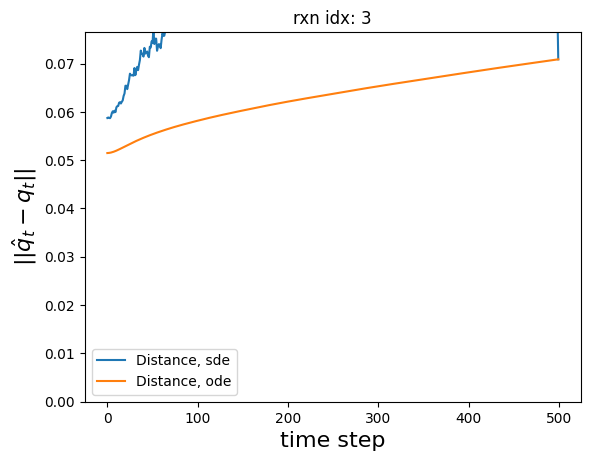

err_at_zero_t =  [0.05872454954425465, 0.05147087751525437]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0


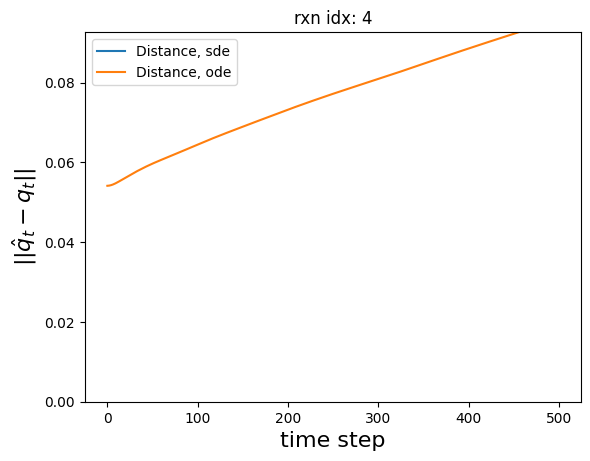

err_at_zero_t =  [0.29014740810794604, 0.05413628530030653]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0


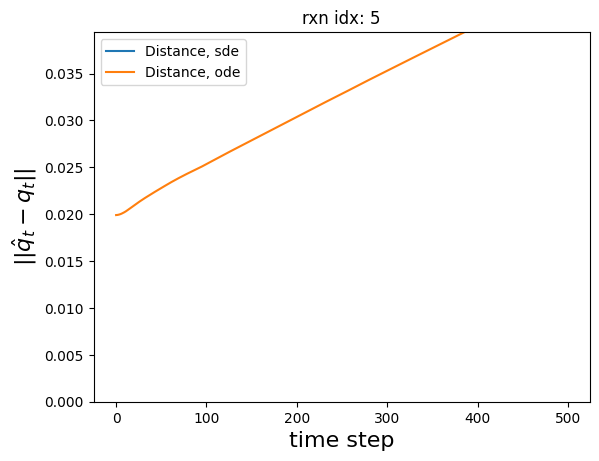

err_at_zero_t =  [0.08380623175994482, 0.019910093504273665]
Done!


In [52]:
"""
sampling_type: "sde", "ode", "hybrid"
coord_type: "Cartesian", "Distance"
"""
num_time_steps = 500

h_coeff = 0.0
verbose = True
verbose = False
# q_type = "DM"
q_type = "morse"
# q_type = "morse+DM"
print(f"q_type = {q_type}")

for idx in [3,4,5]:

    # idx = idx + 50
    err_at_zero_t = []
    v = experiment1(idx, "sde", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type, using_jacobian=True)
    err_at_zero_t.append(v[0].item())
    v = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type, using_jacobian=True)
    err_at_zero_t.append(v[0].item())

    plt.ylim(0.0, v[num_time_steps//2] * 1.2)
    plt.title(f"rxn idx: {idx}")
    plt.legend()
    plt.show()
    print("err_at_zero_t = ", err_at_zero_t)
print("Done!")

q_type = morse
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0


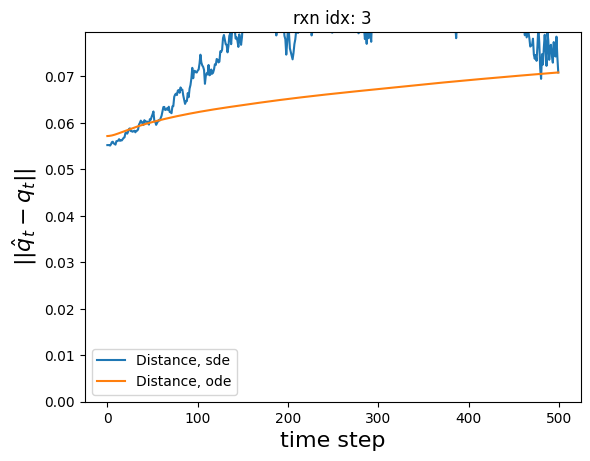

err_at_zero_t =  [0.055234207146190956, 0.05718359859862406]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0


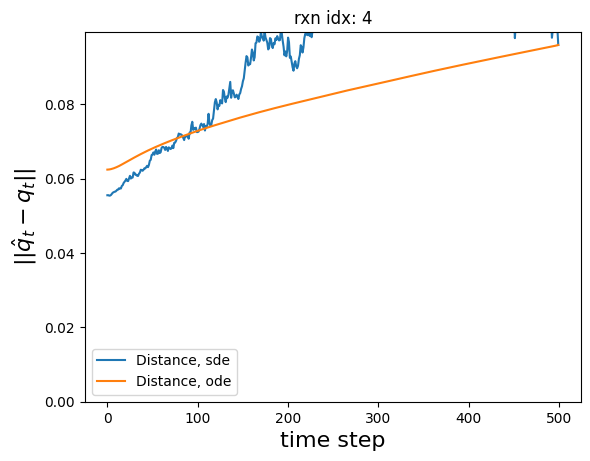

err_at_zero_t =  [0.055529345986979624, 0.0624225633398315]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0


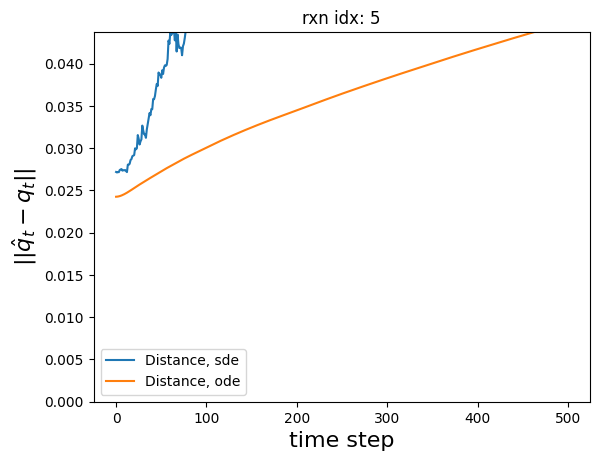

err_at_zero_t =  [0.027187383327470616, 0.024257428330351834]
Done!


In [54]:
"""
sampling_type: "sde", "ode", "hybrid"
coord_type: "Cartesian", "Distance"
"""
num_time_steps = 500


h_coeff = 0.0
verbose = True
verbose = False
# q_type = "DM"
q_type = "morse"
# q_type = "morse+DM"
print(f"q_type = {q_type}")

for idx in [3,4,5]:

    # idx = idx + 50
    err_at_zero_t = []
    v = experiment1(idx, "sde", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type)
    err_at_zero_t.append(v[0].item())
    v = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type)
    err_at_zero_t.append(v[0].item())

    plt.ylim(0.0, v[num_time_steps//2] * 1.2)
    plt.title(f"rxn idx: {idx}")
    plt.legend()
    plt.show()
    print("err_at_zero_t = ", err_at_zero_t)
print("Done!")

## my sampling test

In [8]:
atoms_0 = list(ase.io.iread("wb97xd3/wb97xd3_rxn_ts.xyz"))
# atoms_T = list(ase.io.iread("wb97xd3/wb97xd3_rxn_r.xyz"))
atoms_T = list(ase.io.iread("pm7/pm7_rxn_r.xyz"))
# atoms_T = list(ase.io.iread("pm7/pm7_rxn_ts.xyz"))
# atoms_T = list(ase.io.iread("wb97xd3_geodesic/wb97xd3_geodesic_rxn_ts.xyz"))

# def experiment_my_sampling(idx, sampling_type, coord_type, h_coeff, num_time_steps=200, verbose=False, plot=True, q_type="morse"):
def experiment_my_sampling(idx, sampling_type, coord_type, h_coeff, num_time_steps=200, verbose=False, plot=True, q_type="morse", coeff=None):
    set_seed(0)

    # find matched index
    xT = atoms_T[idx]
    file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
    gt_idx = int(file_name[2:])
    x0 = atoms_0[gt_idx]

    alpha, beta = 1.7, 0.01
    # alpha, beta = 0.0, 1.0
    # alpha, beta = 0.5, 0.01
    wrapper = Wrapper(x0, xT, q_type=q_type, alpha=alpha, beta=beta)
    # wrapper.scaler_factor = 10.0; print(f"Debug: self.scaler_factor set to {wrapper.scaler_factor}")
    
    pos0 = torch.Tensor(x0.get_positions())
    posT = torch.Tensor(xT.get_positions())
    # posT = pos0 + torch.randn_like(pos0) * 0.05

    t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
    dt = (t[1:] - t[:-1]).mean()

    torch.set_printoptions(precision=6, sci_mode=False)
    reverse_traj = [posT]
    x = posT
    v1s = []
    v2s = []

    for idx, i in enumerate(torch.flip(t, dims=(0,))):
        # coeff = 500.0
        x, v1, v2 = wrapper.my_sampling_process(x, i, dt, coeff[idx], pos0, posT, coord=coord_type)
        reverse_traj.append(x)
        v1s.append(v1)
        v2s.append(v2)

    if plot:
        label = f"{coord_type}, {sampling_type}"
        # plt.plot(v2s[::-1])
        # plt.plot(v4s[::-1])
        plt.plot(v1s[::-1], label=label+" DMAE")
        plt.plot(v2s[::-1], label=label+" Morse-RMSD")
        # plt.plot(v)
        # plt.plot(v3s[::-1])
        plt.xlabel(r"time step", fontsize=16)
        if q_type == "morse":
            plt.ylabel(r"||$\hat{q}_t - q_t$||", fontsize=16)
        elif q_type == "DM":
            plt.ylabel(r"||$\hat{d}_t - d_t$||", fontsize=16)
        else:
            raise NotImplementedError
    return v1s, v2s
    # return v1s[::-1]


def save_trajectory(filename, atoms):    
    for trj in mu_hat_list[::-1]:
        xT.set_positions(trj)
        ase.io.write(filename, xT, append=True)

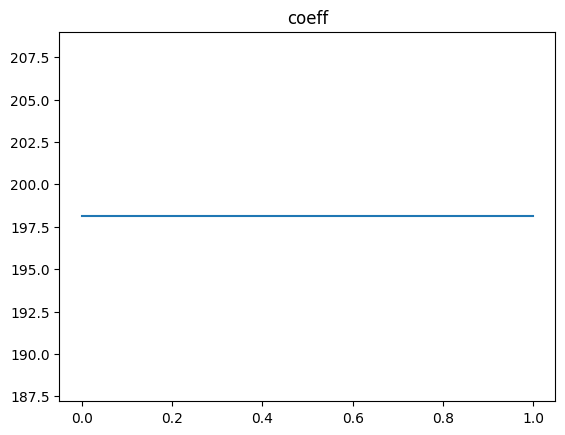

tensor(198.104462)
Debug: self.scaler_factor set to 1.0
Debug: t=0.009000000543892384, diff_d.norm()=0.1629730938523374
Debug: t=0.009000000543892384, diff_pos.norm()=0.004877883483376396
Debug: t=0.009000000543892384, score.norm()=0.9663304815628841
Debug: t=0.009000000543892384, dx.norm()=0.0009663305274611191
Debug: t=0.00800000037997961, diff_d.norm()=0.16291530998523096
Debug: t=0.00800000037997961, diff_pos.norm()=0.004865724393921519
Debug: t=0.00800000037997961, score.norm()=0.9639217116920294
Debug: t=0.00800000037997961, dx.norm()=0.000963921757475854
Debug: t=0.007000000216066837, diff_d.norm()=0.16285779353811727
Debug: t=0.007000000216066837, diff_pos.norm()=0.004853586499996348
Debug: t=0.007000000216066837, score.norm()=0.9615171407501768
Debug: t=0.007000000216066837, dx.norm()=0.0009615171864197905
Debug: t=0.006000000052154064, diff_d.norm()=0.1628005435824968
Debug: t=0.006000000052154064, diff_pos.norm()=0.004841469635299368
Debug: t=0.006000000052154064, score.norm

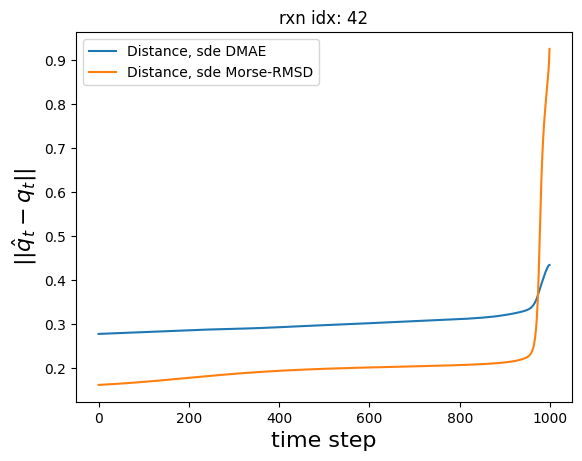

tensor(0.278174) tensor(0.162407, dtype=torch.float64)
Debug: self.scaler_factor set to 1.0
Debug: t=0.009000000543892384, diff_d.norm()=0.2403357968822535
Debug: t=0.009000000543892384, diff_pos.norm()=0.0017125025861831485
Debug: t=0.009000000543892384, score.norm()=0.33925440294416165
Debug: t=0.009000000543892384, dx.norm()=0.0003392544190578811
Debug: t=0.00800000037997961, diff_d.norm()=0.24033096254012545
Debug: t=0.00800000037997961, diff_pos.norm()=0.0017122239195919255
Debug: t=0.00800000037997961, score.norm()=0.339199197849122
Debug: t=0.00800000037997961, dx.norm()=0.0003391992139602194
Debug: t=0.007000000216066837, diff_d.norm()=0.24032612967334746
Debug: t=0.007000000216066837, diff_pos.norm()=0.0017119458579531522
Debug: t=0.007000000216066837, score.norm()=0.3391441125978617
Debug: t=0.007000000216066837, dx.norm()=0.0003391441287063427
Debug: t=0.006000000052154064, diff_d.norm()=0.24032129827922669
Debug: t=0.006000000052154064, diff_pos.norm()=0.0017116675806475915

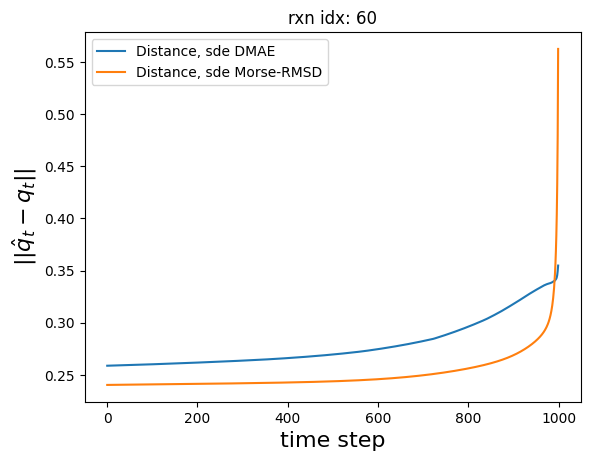

tensor(0.258699) tensor(0.240288, dtype=torch.float64)
Debug: self.scaler_factor set to 1.0
Debug: t=0.009000000543892384, diff_d.norm()=0.18220655464922772
Debug: t=0.009000000543892384, diff_pos.norm()=0.0014989727392793351
Debug: t=0.009000000543892384, score.norm()=0.2969531875728208
Debug: t=0.009000000543892384, dx.norm()=0.00029695320167734033
Debug: t=0.00800000037997961, diff_d.norm()=0.18220167164649667
Debug: t=0.00800000037997961, diff_pos.norm()=0.001497133082145862
Debug: t=0.00800000037997961, score.norm()=0.2965887432867369
Debug: t=0.00800000037997961, dx.norm()=0.0002965887573739463
Debug: t=0.007000000216066837, diff_d.norm()=0.1821968004886402
Debug: t=0.007000000216066837, diff_pos.norm()=0.0014952969926645952
Debug: t=0.007000000216066837, score.norm()=0.2962250057684727
Debug: t=0.007000000216066837, dx.norm()=0.0002962250198384055
Debug: t=0.006000000052154064, diff_d.norm()=0.1821919411390198
Debug: t=0.006000000052154064, diff_pos.norm()=0.001493464652337944
D

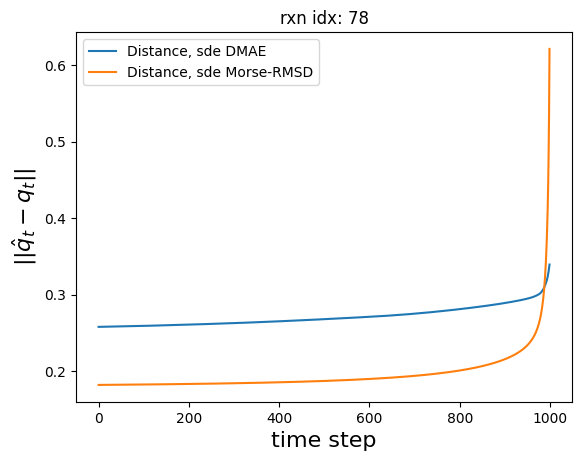

tensor(0.258013) tensor(0.182158, dtype=torch.float64)
Debug: self.scaler_factor set to 1.0
Debug: t=0.009000000543892384, diff_d.norm()=0.049388425830051784
Debug: t=0.009000000543892384, diff_pos.norm()=0.0007107920868914795
Debug: t=0.009000000543892384, score.norm()=0.1408110837328769
Debug: t=0.009000000543892384, dx.norm()=0.00014081109042104448
Debug: t=0.00800000037997961, diff_d.norm()=0.0493843789290323
Debug: t=0.00800000037997961, diff_pos.norm()=0.000708570082147918
Debug: t=0.00800000037997961, score.norm()=0.1403708946793256
Debug: t=0.00800000037997961, dx.norm()=0.00014037090134658533
Debug: t=0.007000000216066837, diff_d.norm()=0.04938035695394023
Debug: t=0.007000000216066837, diff_pos.norm()=0.0007063579184331074
Debug: t=0.007000000216066837, score.norm()=0.1399326551774773
Debug: t=0.007000000216066837, dx.norm()=0.00013993266182392178
Debug: t=0.006000000052154064, diff_d.norm()=0.04937635972497326
Debug: t=0.006000000052154064, diff_pos.norm()=0.0007041538414642

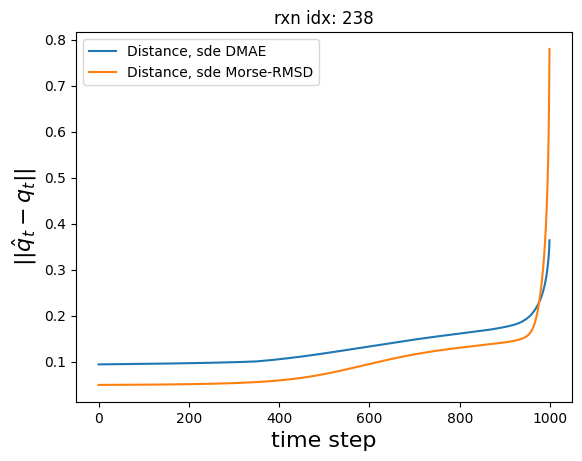

tensor(0.094000) tensor(0.049349, dtype=torch.float64)
Debug: self.scaler_factor set to 1.0
Debug: t=0.009000000543892384, diff_d.norm()=0.06774345405499536
Debug: t=0.009000000543892384, diff_pos.norm()=0.0024052081687903027
Debug: t=0.009000000543892384, score.norm()=0.4764824694823015
Debug: t=0.009000000543892384, dx.norm()=0.0004764824921140044
Debug: t=0.00800000037997961, diff_d.norm()=0.06770962623459778
Debug: t=0.00800000037997961, diff_pos.norm()=0.002403030046544865
Debug: t=0.00800000037997961, score.norm()=0.47605097374741784
Debug: t=0.00800000037997961, dx.norm()=0.00047605099635862576
Debug: t=0.007000000216066837, diff_d.norm()=0.06767584277295502
Debug: t=0.007000000216066837, diff_pos.norm()=0.0024008563468819626
Debug: t=0.007000000216066837, score.norm()=0.4756203541458665
Debug: t=0.007000000216066837, dx.norm()=0.00047562037673662107
Debug: t=0.006000000052154064, diff_d.norm()=0.06764210355631863
Debug: t=0.006000000052154064, diff_pos.norm()=0.0023986872226408

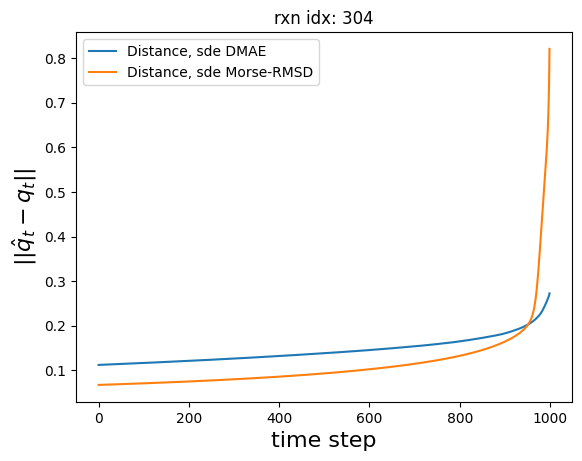

tensor(0.112269) tensor(0.067407, dtype=torch.float64)


In [9]:
# num_time_steps = 500
num_time_steps = 1000
h_coeff = 0.0
verbose = True
verbose = False
q_type = "DM"
q_type = "morse"

t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
# coeff = torch.ones(num_time_steps) *  500.0
coeff = torch.exp(- 5.0 * t**2) * 500
coeff = torch.ones(len(coeff)) * coeff.mean()
plt.title("coeff")
plt.plot(list(t)[::-1], coeff)
# plt.plot(list(t)[::-1], coeff * 1 / num_time_steps)
plt.show()
print(coeff[-1])

for idx in [42,60,78,238,304]:
# for idx in range(10):
# for idx in np.random.randint(0, 1000, size=5):
    err_at_zero_t = []
    v = experiment_my_sampling(idx, "sde", "Distance", h_coeff, num_time_steps, verbose=verbose, q_type=q_type, coeff=coeff)
    plt.title(f"rxn idx: {idx}")
    plt.legend()
    plt.show()
    print(v[0][-1], v[1][-1])  # DMAE, q norm

# Hybrid sampling (d-space sampling + q-space sampling)



In [10]:
class HybridSampler:
    def __init__(self, atoms_0, atoms_T):
        self.atoms_0 = atoms_0
        self.atoms_T = atoms_T
        self.d_sampler = Wrapper(atoms_0, atoms_T, q_type="DM")
        self.q_sampler = Wrapper(atoms_0, atoms_T, q_type="morse")
        # self.q_sampler.scaler_factor = 2.0; print(f"Debug: self.scaler_factor set to {self.q_sampler.scaler_factor}")
        
        self.i_t = 0
        return

    def hybrid_sampling_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=False, sampling_type="sde"):
        if sampling_type == "sde":
            if self.i_t % 2 == 0:
                x_tm1, v1, v2, v3, v4 = self.d_sampler.reverse_diffusion_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
            else:
                x_tm1, v1, v2, v3, v4 = self.q_sampler.reverse_diffusion_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
        elif sampling_type == "ode":
            if self.i_t % 2 == 0:
                x_tm1, v1, v2, v3, v4 = self.d_sampler.reverse_ode_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
            else:
                x_tm1, v1, v2, v3, v4 = self.q_sampler.reverse_ode_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
        self.i_t += 1
        return x_tm1, v1, v2, v3, v4

    def hybrid_sampling_process2(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=False, sampling_type="sde"):
        w_q = 0.5
        if sampling_type == "sde":
            x_tm1, v1, v2, v3, v4 = self.d_sampler.reverse_diffusion_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
            x_tm2, v1, v2, v3, v4 = self.q_sampler.reverse_diffusion_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
            # x_tm1 = (x_tm1 + x_tm2) / 2
            x_tm1 = (1 - w_q) * x_tm1 + w_q * x_tm2
        elif sampling_type == "ode":
            x_tm1, v1, v2, v3, v4 = self.d_sampler.reverse_ode_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
            x_tm2, v1, v2, v3, v4 = self.q_sampler.reverse_ode_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
            # x_tm1 = (x_tm1 + x_tm2) / 2
            x_tm1 = (1 - w_q) * x_tm1 + w_q * x_tm2
        return x_tm1, v1, v2, v3, v4

    def d_sampling_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=False, sampling_type="sde"):
        if sampling_type == "sde":
            x_tm1, v1, v2, v3, v4 = self.d_sampler.reverse_diffusion_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
        elif sampling_type == "ode":
            x_tm1, v1, v2, v3, v4 = self.d_sampler.reverse_ode_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
        return x_tm1, v1, v2, v3, v4

    def q_sampling_process(self, x_t, t, dt, params, x_0, x_T, coord="Cartesian", h_coeff=0.0, verbose=False, sampling_type="sde"):
        if sampling_type == "sde":
            x_tm1, v1, v2, v3, v4 = self.q_sampler.reverse_diffusion_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
        elif sampling_type == "ode":
            x_tm1, v1, v2, v3, v4 = self.q_sampler.reverse_ode_process(x_t, t, dt, params, x_0, x_T, coord=coord, h_coeff=h_coeff, verbose=verbose)
        return x_tm1, v1, v2, v3, v4

In [11]:
atoms_0 = list(ase.io.iread("wb97xd3/wb97xd3_rxn_ts.xyz"))
# atoms_T = list(ase.io.iread("wb97xd3/wb97xd3_rxn_r.xyz"))
# atoms_T = list(ase.io.iread("pm7/pm7_rxn_r.xyz"))
atoms_T = list(ase.io.iread("pm7/pm7_rxn_ts.xyz"))
# atoms_T = list(ase.io.iread("wb97xd3_geodesic/wb97xd3_geodesic_rxn_ts.xyz"))


def experiment_hybrid_sampling(idx, sampling_type, coord_type, h_coeff, num_time_steps=200, verbose=False, plot=True):
    set_seed(0)
    # set_seed(2)

    # find matched index
    xT = atoms_T[idx]
    file_name = list(xT.info.keys())[0].split("/")[-1].split(".")[0]
    gt_idx = int(file_name[2:])
    x0 = atoms_0[gt_idx]

    hybrid_sampler = HybridSampler(x0, xT)
    
    pos0 = torch.Tensor(x0.get_positions())
    posT = torch.Tensor(xT.get_positions())
    # posT = pos0 + torch.randn_like(pos0) * 0.05

    t = torch.linspace(0, 1, num_time_steps + 1)[:-1]
    dt = (t[1:] - t[:-1]).mean()

    torch.set_printoptions(precision=6, sci_mode=False)
    reverse_traj = [posT]
    x = posT
    v1s, v2s, v3s, v4s = [], [], [], []

    for idx, i in enumerate(torch.flip(t, dims=(0,))):
        # x, v1, v2, v3, v4 = hybrid_sampler.hybrid_sampling_process(x, i, dt, params, pos0, posT, coord=coord_type, sampling_type=sampling_type)
        # x, v1, v2, v3, v4 = hybrid_sampler.hybrid_sampling_process2(x, i, dt, params, pos0, posT, coord=coord_type, sampling_type=sampling_type)
        x, v1, v2, v3, v4 = hybrid_sampler.d_sampling_process(x, i, dt, params, pos0, posT, coord=coord_type, sampling_type=sampling_type)
        reverse_traj.append(x)
        v1s.append(v1);        v2s.append(v2);        v3s.append(v3);        v4s.append(v4)

    for j in range(0):
        for idx, i in enumerate(torch.flip(t, dims=(0,))):
            if idx < num_time_steps - 100:
                continue
            # x, v1, v2, v3, v4 = hybrid_sampler.hybrid_sampling_process(x, i, dt, params, pos0, posT, coord=coord_type, sampling_type=sampling_type)
            # x, v1, v2, v3, v4 = hybrid_sampler.hybrid_sampling_process2(x, i, dt, params, pos0, posT, coord=coord_type, sampling_type=sampling_type)
            x, v1, v2, v3, v4 = hybrid_sampler.d_sampling_process(x, i, dt, params, pos0, posT, coord=coord_type, sampling_type=sampling_type)
            reverse_traj.append(x)
            v1s.append(v1);        v2s.append(v2);        v3s.append(v3);        v4s.append(v4)
        

    if plot:
        label = f"{coord_type}, {sampling_type}"
        ## plt.plot(v2s[::-1], label=label)
        plt.plot(v4s[::-1], label=label)
        plt.xlabel(r"time step", fontsize=16)
        if q_type == "morse":
            plt.ylabel(r"||$\hat{q}_t - q_t$||", fontsize=16)
        # elif q_type == "DM":
        elif q_type in ["morse", "morse+DM"]:
            plt.ylabel(r"||$\hat{d}_t - d_t$||", fontsize=16)
        else:
            raise NotImplementedError
    return v4s[::-1]  # q norm
    # return v2s[::-1]  # DMAE


def save_trajectory(filename, atoms):    
    for trj in mu_hat_list[::-1]:
        xT.set_positions(trj)
        ase.io.write(filename, xT, append=True)

Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0


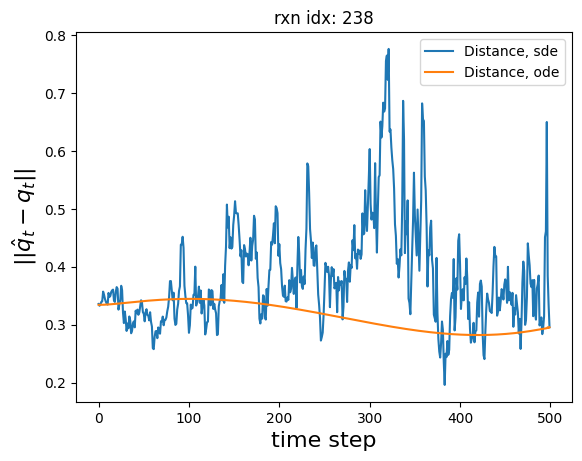

err_at_zero_t =  [0.3357883414218219, 0.33422845305210813]
Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0


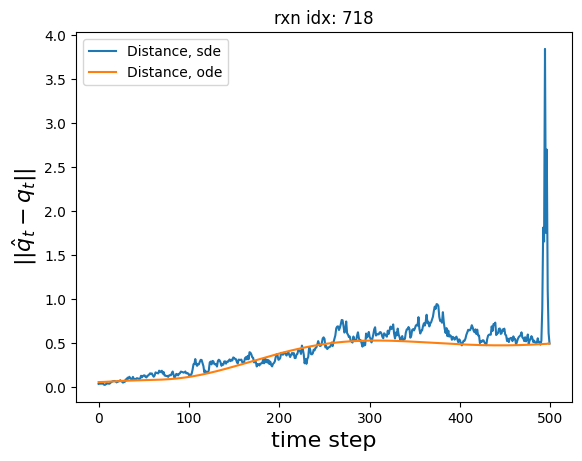

err_at_zero_t =  [0.03985236306261637, 0.06115562072447895]
Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0
Debug: self.scaler_factor set to 1.0


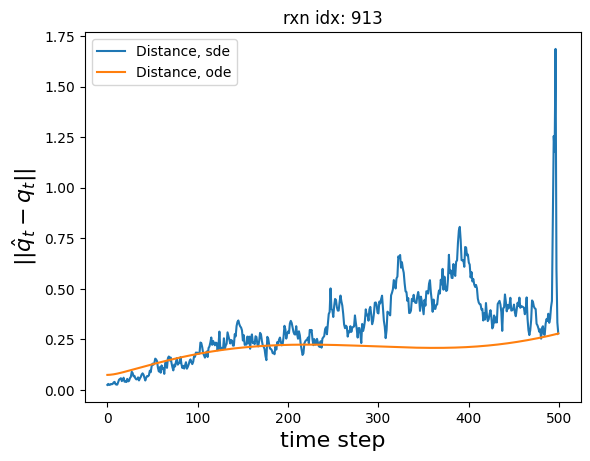

err_at_zero_t =  [0.02489339368640088, 0.0743585490202776]
Done!!!!!!!!


In [12]:
"""
sampling_type: "sde", "ode", "hybrid"
coord_type: "Cartesian", "Distance"
"""
num_time_steps = 500
# num_time_steps = 50
# num_time_steps = 1000
# num_time_steps = 200
# num_time_steps = 100

h_coeff = 0.0
verbose = True
verbose = False


# for idx in [3, 7]:
# for idx in [3,4,5,6,7,8,9,10]:
# for idx in [60, 320]:
# for idx in [42,60,78,238,304,344,458,718,746,774,884,913]:
# for idx in [42,60,78,238,304]:
for idx in [238, 718, 913]:
    err_at_zero_t = []
    v = experiment_hybrid_sampling(idx, "sde", "Distance", h_coeff, num_time_steps, verbose=verbose)
    err_at_zero_t.append(v[0].item())
    v = experiment_hybrid_sampling(idx, "ode", "Distance", h_coeff, num_time_steps, verbose=verbose)
    err_at_zero_t.append(v[0].item())
    plt.title(f"rxn idx: {idx}")
    plt.legend()
    plt.show()
    print("err_at_zero_t = ", err_at_zero_t)
print("Done!!!!!!!!")

# =============================================================

In [13]:
"""
sampling_type: "sde", "ode", "hybrid"
coord_type: "Cartesian", "Distance"
"""
# num_time_steps = 70
num_time_steps = 200
# num_time_steps = 1000
h_coeff = 0.0
plot = False
thr = 0.01
q_type = "morse"

print(f"* num_time_steps: {num_time_steps}")
print(f"* h_coeff: {h_coeff}")
print(f"* plot: {plot}")
print(f"* thr: {thr}")

import pickle
test_index_list = pickle.load(open("/home/share/DATA/NeuralOpt/data/data_split.pkl", "rb"))["test_index"]

## get index
idx_list = []
for _xT in atoms_T:
    file_info = list(_xT.info.keys())[0].split("/")[-1].split(".")[0]
    _idx = int(file_info[2:])
    idx_list.append(_idx)
idx_list = set(idx_list + list(test_index_list))
print(len(idx_list))
# print(idx_list)

for idx in idx_list:
    err_at_zero_t = []
    v = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, plot=plot, q_type=q_type)
    err_at_zero_t.append(v[0].item())
    v = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, plot=plot, q_type=q_type)
    err_at_zero_t.append(v[0].item())
    v = experiment1(idx, "sde", "Cartesian", h_coeff, num_time_steps, plot=plot, q_type=q_type)
    err_at_zero_t.append(v[0].item())
    v = experiment1(idx, "ode", "Cartesian", h_coeff, num_time_steps, plot=plot, q_type=q_type)
    err_at_zero_t.append(v[0].item())

    satisfy_thr = [_ < thr for _ in err_at_zero_t]
    if False in satisfy_thr:
        print(f"idx={idx}, err_at_zero_t={err_at_zero_t}")
print("Done!!!")

* num_time_steps: 200
* h_coeff: 0.0
* plot: False
* thr: 0.01
8275
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
idx=4, err_at_zero_t=[0.062407590448856354, 0.062407590448856354, 0.005277550779283047, 0.0005587086197920144]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
idx=6, err_at_zero_t=[0.029902232810854912, 0.029902232810854912, 0.0032537993974983692, 0.000517065345775336]
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01
Debug: self.scaler_factor set to 1.0
Debug: alpha, beta = 1.7, 0.01

KeyboardInterrupt: 

In [ ]:
"""
sampling_type: "sde", "ode", "hybrid"
coord_type: "Cartesian", "Distance"
"""
# num_time_steps = 70
num_time_steps = 200
# num_time_steps = 1000
h_coeff = 0.0
plot = False
thr = 0.01
q_type = "morse"

print(f"* num_time_steps: {num_time_steps}")
print(f"* h_coeff: {h_coeff}")
print(f"* plot: {plot}")
print(f"* thr: {thr}")

import pickle
test_index_list = pickle.load(open("/home/share/DATA/NeuralOpt/data/data_split.pkl", "rb"))["test_index"]

## get index
idx_list = []
for _xT in atoms_T:
    file_info = list(_xT.info.keys())[0].split("/")[-1].split(".")[0]
    _idx = int(file_info[2:])
    idx_list.append(_idx)
idx_list = set(idx_list + list(test_index_list))
print(len(idx_list))
# print(idx_list)

for idx in idx_list:
    err_at_zero_t = []
    v = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, plot=plot, q_type=q_type)
    err_at_zero_t.append(v[0].item())
    v = experiment1(idx, "ode", "Distance", h_coeff, num_time_steps, plot=plot, q_type=q_type)
    err_at_zero_t.append(v[0].item())
    v = experiment1(idx, "sde", "Cartesian", h_coeff, num_time_steps, plot=plot, q_type=q_type)
    err_at_zero_t.append(v[0].item())
    v = experiment1(idx, "ode", "Cartesian", h_coeff, num_time_steps, plot=plot, q_type=q_type)
    err_at_zero_t.append(v[0].item())

    satisfy_thr = [_ < thr for _ in err_at_zero_t]
    if False in satisfy_thr:
        print(f"idx={idx}, err_at_zero_t={err_at_zero_t}")
print("Done!!!")